### Imports

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix#,plot_confusion_matrix
from sklearn import metrics
import itertools

%matplotlib inline

### Functions

In [2]:
def dataloader_batch(train_dataset,test_dataset,batch_size=128):
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True)
    # to prevent unwanted correlation in train_data we shuffle train data
    test_loader  = torch.utils.data.DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=False)
    return train_loader,test_loader
    

def create_model_and_train(train_loader,test_loader,n_epochs=10):
    
    model = nn.Sequential(
        nn.Linear(784,128),
        nn.ReLU(),
        nn.Linear(128,10),
        )
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())
    
    train_loader,test_loader = dataloader_batch(train_dataset,test_dataset,batch_size=128)

    train_losses = np.zeros(n_epochs)
    test_losses = np.zeros(n_epochs)

#     train_accs = np.zeros(n_epochs)
#     test_accs = np.zeros(n_epochs)
    
    
    for it in range(n_epochs):
        train_loss=[]
        for inputs,targets in train_loader:
            inputs,targets = inputs.to(device), targets.to(device)
            inputs = inputs.view(-1,784)
#             print(inputs.shape)
            
            optimizer.zero_grad()
            outputs = model(inputs)
        
            loss = criterion(outputs, targets)

            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
            
        train_loss = np.mean(train_loss)
        train_losses[it]=train_loss

        
        #test
        test_loss=[]
        for inputs,targets in test_loader:
            inputs,targets = inputs.to(device), targets.to(device)
            inputs = inputs.view(-1,784)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())
            
        test_loss = np.mean(test_loss)
        test_losses[it]=test_loss
        
#         train_accs[it]= model_result_printer(model,targets,predict_model(model,outputs,mode=1,logit=logit),usage="in",metrics_lists=[metrics.accuracy_score])[0]
#         test_accs[it] = model_result_printer(model,test_targets,predict_model(model,test_outputs,mode=1,logit=logit),usage="in",metrics_lists=[metrics.accuracy_score])[0]
        
        
        if it%1==0:
            print("{:20}".format(f"epoch {it+1}/{n_epochs}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}"))

    return model ,device, train_losses, test_losses#, train_accs, test_accs


def plot_test_and_train_metric(train, test, metric):
    plt.plot(train, label=f"train {metric}")
    plt.plot(test, label =f"test {metric}")
    plt.legend()
    plt.show
    

def acc_compouter(model,device,data_loader):
    n_correct=0.
    n_total=0.
    
    for inputs,targets in data_loader:
        inputs,targets = inputs.to(device), targets.to(device)
        inputs = inputs.view(-1,784)
        outputs = model(inputs)
        
        _,predictions = torch.max(outputs,1)
        # 1 is the axis and  _ is the max value that is not needed here
        
        n_correct += (predictions == targets).sum().item()
        # .item() from torch to simple python data type
        n_total += targets.shape[0]
        
    train_acc = n_correct/n_total

    return train_acc


def predict_model(model,data_loader,dataset,device):
    x = dataset.data.numpy()
    y = dataset.targets.numpy()
    p = np.array([])
    for inputs,targets in data_loader:
        inputs = inputs.to(device)
        inputs = inputs.view(-1,784)
        
        outputs = model(inputs)
        _,predictions = torch.max(outputs,1)
        p = np.concatenate((p,predictions.cpu().numpy()))
        
    return p,y,x

def plot_confusion_matrix(cm, classes, normalize=False, title="Confusion matrix", cmap=plt.cm.Blues):
    if normalize:
        cm=cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")
    print(cm)
    
    plt.imshow(cm, interpolation="nearest",cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = ".2f" if normalize else "d"
    thresh = cm.max()/2.
    
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,format(cm[i,j],fmt),
                 horizontalalignment="center",
                 color="white" if cm[i,j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()
    

### Load Data

In [3]:
train_dataset = torchvision.datasets.MNIST(root=".",train=True,transform=transforms.ToTensor(),download=True)

In [4]:
train_dataset.data

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        ...,

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0,

In [5]:
train_dataset.data.max()

tensor(255, dtype=torch.uint8)

In [6]:
train_dataset.data.shape

torch.Size([60000, 28, 28])

In [7]:
train_dataset.targets

tensor([5, 0, 4,  ..., 5, 6, 8])

In [8]:
test_dataset = torchvision.datasets.MNIST(root=".",train=False,transform=transforms.ToTensor(),download=True)

In [9]:
test_dataset.data.shape

torch.Size([10000, 28, 28])

### Create model and dataloder (batch)

In [10]:
#check dataloader way of working
temp_loader = torch.utils.data.DataLoader(dataset=train_dataset,batch_size=1,shuffle=True)
for x,y in temp_loader:
    print(x)
    print(x.shape)
    print(y.shape)
    break

tensor([[[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [11]:
train_dataset.transform(train_dataset.data.numpy()).max()

tensor(1.)

In [12]:
train_loader,test_loader = dataloader_batch(train_dataset,test_dataset,batch_size=128)
model ,device ,train_losses, test_losses = create_model_and_train(train_loader,test_loader,n_epochs=10)

epoch 1/10, Train Loss: 0.0595, Test Loss: 0.2320
epoch 2/10, Train Loss: 0.0426, Test Loss: 0.1589
epoch 3/10, Train Loss: 0.0174, Test Loss: 0.1215
epoch 4/10, Train Loss: 0.0086, Test Loss: 0.1060
epoch 5/10, Train Loss: 0.0052, Test Loss: 0.0949
epoch 6/10, Train Loss: 0.0051, Test Loss: 0.0908
epoch 7/10, Train Loss: 0.0015, Test Loss: 0.0831
epoch 8/10, Train Loss: 0.0016, Test Loss: 0.0753
epoch 9/10, Train Loss: 0.0015, Test Loss: 0.0746
epoch 10/10, Train Loss: 0.0010, Test Loss: 0.0723


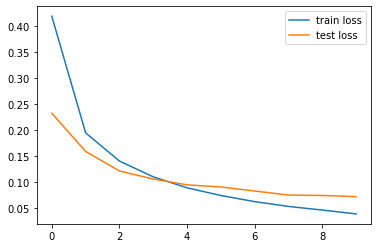

In [13]:
plot_test_and_train_metric(train_losses, test_losses,"loss")

In [17]:
train_acc = acc_compouter(model,device,train_loader)
print(f"train acc: {train_acc}")

test_acc = acc_compouter(model,device,test_loader)
print(f"test acc: {test_acc}")

train acc: 0.9923166666666666
test acc: 0.9775


In [18]:
p_test,y_test,x_test = predict_model(model,test_loader,test_dataset,device)

Confusion matrix, without normalization
[[ 970    0    2    2    2    0    1    1    1    1]
 [   0 1121    5    0    0    1    3    1    4    0]
 [   2    0 1007    3    2    0    2    3   12    1]
 [   0    0    2  995    0    1    0    4    5    3]
 [   0    0    4    2  956    1    6    2    1   10]
 [   2    1    0    7    0  872    3    0    6    1]
 [   4    3    2    1    2    6  939    0    1    0]
 [   0    3   11    7    1    0    0  999    1    6]
 [   3    0    3    5    2    5    5    5  944    2]
 [   1    4    1    8    8    5    1    5    4  972]]


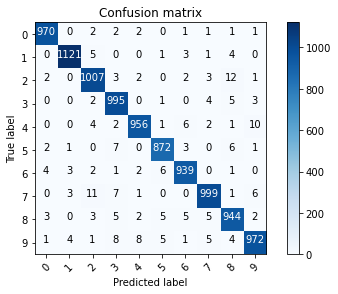

In [19]:
cm = confusion_matrix(y_test,p_test)
plot_confusion_matrix(cm, list(range(10)))

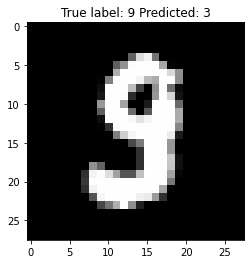

In [20]:
misclassified_idx = np.where(p_test!=y_test)[0]
i = np.random.choice(misclassified_idx)
plt.imshow(x_test[i],cmap="gray")
plt.title("True label: %s Predicted: %s" % (y_test[i], int(p_test[i])));